In [1]:
import re
import warnings
from pathlib import Path

warnings.simplefilter(action="ignore", category=FutureWarning)

import lmfit as lm
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns
import xrayutilities as xu
from mplstylize import mpl_tools
from scipy.optimize import curve_fit
from xrayutilities.materials.elements import O, Ru, Sr

from acoustic_resonators.asops.config import paths as asops_paths

%config InlineBackend.figure_format = 'retina'

In [2]:
def gaussian(x, amp, cen, sigma):
    return amp * np.exp(-((x - cen) ** 2) / (2.0 * sigma**2))


def lorentzian(x, amp, cen, sigma):
    return amp / (1 + ((x - cen) / sigma) ** 2)


def pseudovoigt(x, amp, cen, sigma, fraction):
    return fraction * gaussian(x, amp, cen, sigma) + (1 - fraction) * lorentzian(
        x, amp, cen, sigma
    )


def logpseudovoigt(x, amp, cen, sigma, fraction):
    return np.log10(pseudovoigt(x, amp, cen, sigma, fraction))


def log2pseudovoigt(x, amp1, cen1, sigma1, fraction1, amp2, cen2, sigma2, fraction2):
    return np.log10(
        pseudovoigt(x, amp1, cen1, sigma1, fraction1)
        + pseudovoigt(x, amp2, cen2, sigma2, fraction2)
    )


def to_distance(x):
    lda = 0.15406  # [nm], Cu K-alpha
    return lda / (2 * np.sin(np.deg2rad(x) / 2)) * 2

[(0.385, 0.405)]

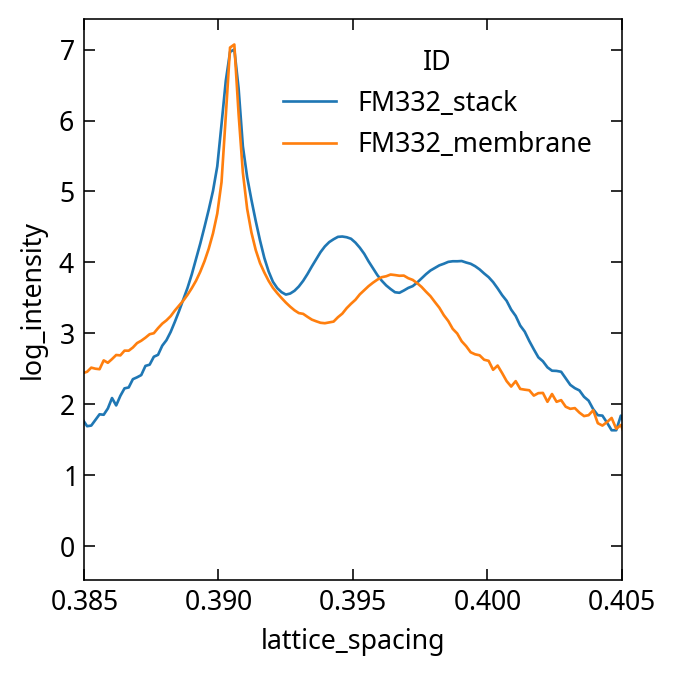

In [3]:
def load_csv(filename):
    index = None
    with open(filename, "r") as file:
        for line_number, line in enumerate(file):
            if line.strip() == "[Data]":
                index = line_number + 1
                break

        return pl.read_csv(
            filename,
            skip_rows=index,
            has_header=True,
            schema={"2theta": pl.Float64, "intensity": pl.Float64},
            truncate_ragged_lines=True,
        )


delft_FM332 = pl.concat(
    [
        load_csv("data/liftoff/FM332_XRD.txt").with_columns(
            pl.lit("FM332_stack").alias("ID")
        ),
        load_csv("data/liftoff/FM332_membrane_XRD.txt").with_columns(
            pl.lit("FM332_membrane").alias("ID")
        ),
    ]
).with_columns(
    (pl.col("intensity") - pl.col("intensity").slice(0, 50).mean())
    .log10()
    .alias("log_intensity"),
    pl.col("2theta").map_batches(to_distance).alias("lattice_spacing"),
)

sns.lineplot(delft_FM332, x="lattice_spacing", y="log_intensity", hue="ID").set(
    xlim=(0.385, 0.405)
)

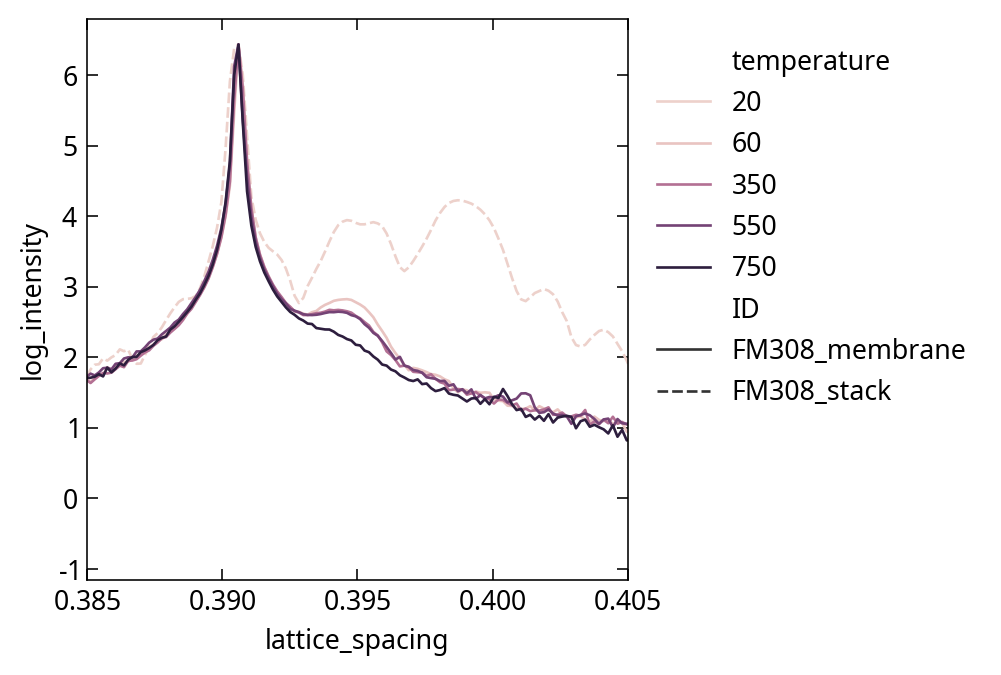

In [4]:
delft_FM308 = (
    pl.read_csv(asops_paths.processed_data / "xrd_FM308.csv")
    .with_columns(
        pl.col("2theta").map_batches(to_distance).alias("lattice_spacing"),
        pl.col("intensity").log10().alias("log_intensity"),
    )
    .with_columns(pl.col("log_intensity") - pl.col("log_intensity").slice(0, 50).mean())
)

fig, ax = plt.subplots(figsize=(5.1, 3.4))
g = sns.lineplot(
    delft_FM308,
    x="lattice_spacing",
    y="log_intensity",
    hue="temperature",
    style="ID",
    ax=ax,
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
ax.set(xlim=(0.385, 0.405))
plt.show()

In [5]:
folder = Path("data/heating/XRDs/")
filenames = list(folder.glob("*"))

xrd_data = pl.concat(
    pl.DataFrame(
        xu.io.getxrdml_scan(filename),
        schema={"2theta": pl.Float64, "intensity": pl.Float64},
    ).with_columns(
        pl.lit(float(re.search(r"(\d+)(?=øC)", filename.name).group())).alias(
            "temperature"
        )
    )
    for filename in filenames
).sort("temperature", "2theta")

normalized_intensity = pl.col("intensity") / pl.col("intensity").max()
log_intensity = pl.col("intensity").log10()

xrd_data = (
    xrd_data.with_columns(
        normalized_intensity.over("temperature").alias("intensity"),
    )
    .with_columns(
        log_intensity.alias("log_intensity"),
    )
    .with_columns(
        (pl.col("log_intensity") - pl.col("log_intensity").slice(0, 50).mean())
    )
    .with_columns(
        pl.col("2theta").map_batches(to_distance).alias("lattice_spacing"),
    )
)


temperature_order = {27: 1} | {100 + 50 * i: i + 2 for i in range(14)} | {25: 16}

xrd_data = xrd_data.with_columns(
    pl.col("temperature").replace(temperature_order).cast(pl.Int32).alias("number")
)

/Users/monochromatti/miniconda3/envs/scicomp/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


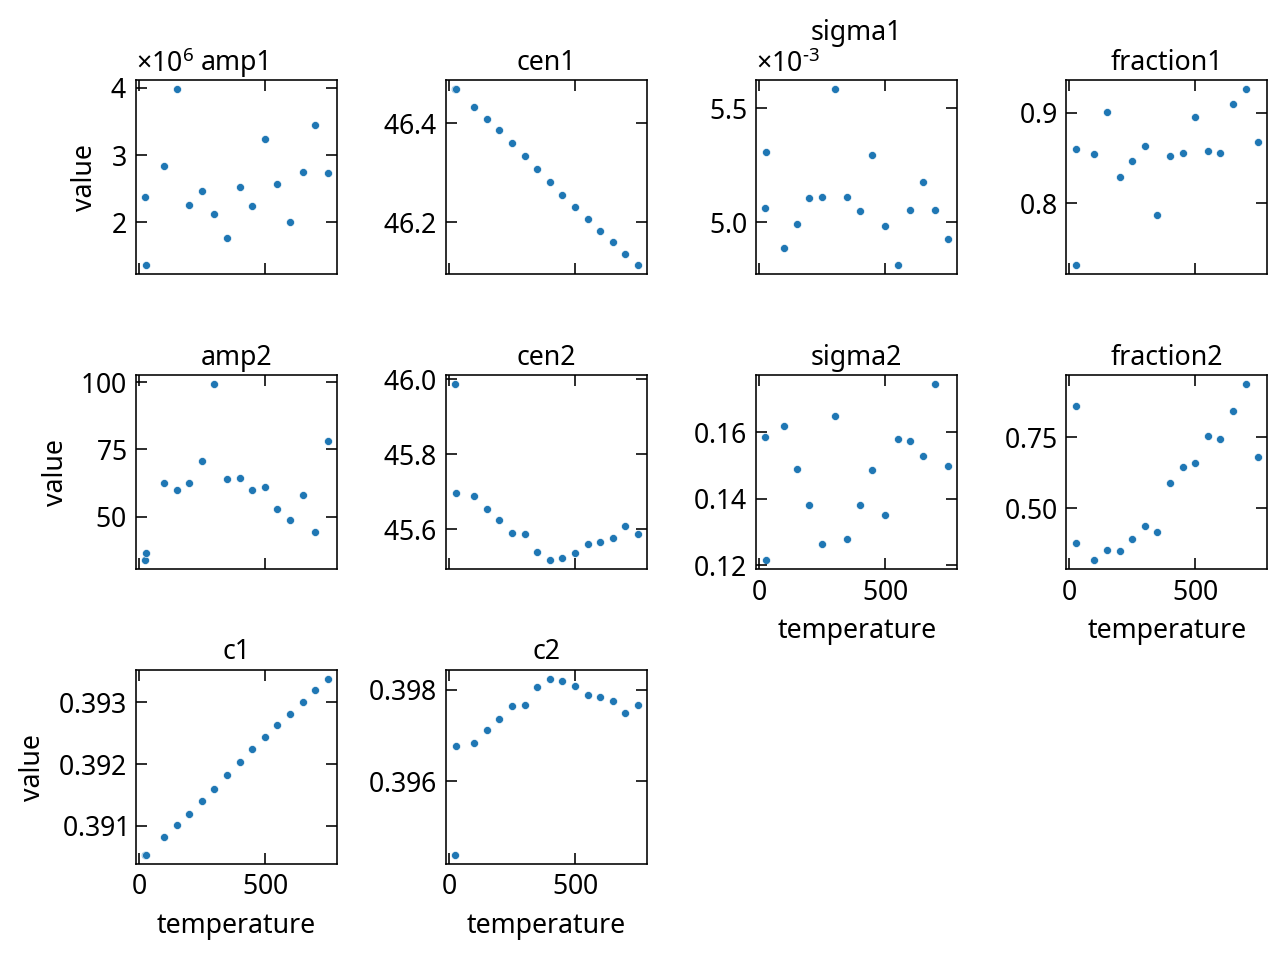

In [6]:
pseudovoigt_model = lm.Model(log2pseudovoigt)
pseudovoigt_params = lm.Parameters()
best_params = []


def fit_xrd(data: pl.DataFrame):
    x = data["2theta"].to_numpy()
    y = data["log_intensity"].to_numpy()
    temperature = data["temperature"][0]

    fit_range = slice(250, 600)
    center_sto = 46.5 - (46.5 - 46.1) / 725 * temperature

    # (name, value, vary, min, max)
    pseudovoigt_params.add_many(
        ("amp1", 3e6, True, 1e6, 4e6),
        ("cen1", center_sto, True, 0, None),
        ("sigma1", 0.005, True, 0, 1e-2),
        ("fraction1", 0.9, True, 0, 1),
        ("amp2", 60, True, 10, 100),
        ("cen2", 45.8, True, 45.2, 46.3),
        ("sigma2", 0.15, True, 0.05, 0.35),
        ("fraction2", 1, True, 0, 1),
    )

    pseudovoigt_fitresult = pseudovoigt_model.fit(
        y[fit_range], pseudovoigt_params, x=x[fit_range], method="nelder-mead"
    )
    best_params.append(
        {"temperature": temperature} | pseudovoigt_fitresult.params.valuesdict()
    )

    data = data.with_columns(pl.lit(pseudovoigt_fitresult.eval(x=x)).alias("best_fit"))

    return data


xrd_data = xrd_data.group_by(["temperature"]).map_groups(fit_xrd)
best_params = pl.DataFrame(best_params).with_columns(
    pl.col("cen1").map_batches(to_distance).alias("c1"),
    pl.col("cen2").map_batches(to_distance).alias("c2"),
)

g = sns.relplot(
    best_params.melt(id_vars="temperature"),
    x="temperature",
    y="value",
    col="variable",
    col_wrap=4,
    facet_kws=dict(sharey=False, despine=False),
    height=1.7,
)
g.set_titles("{col_name}")
plt.show()

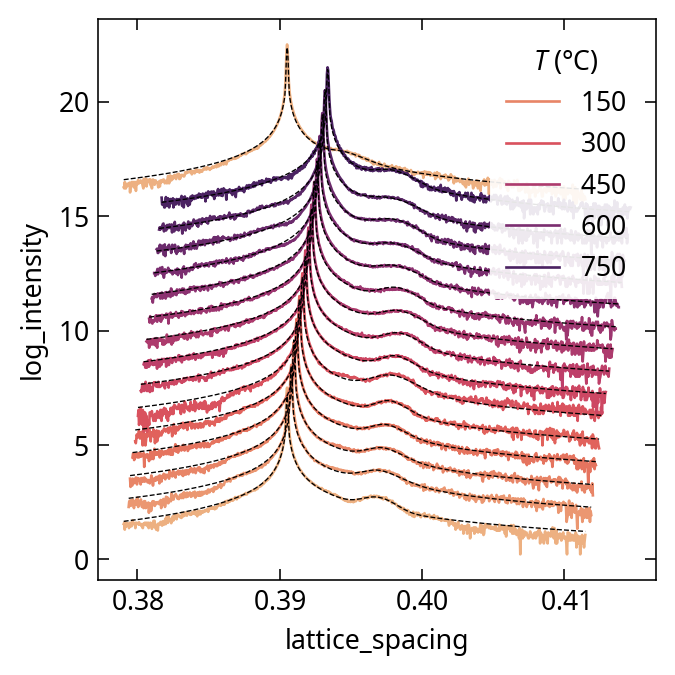

In [7]:
def add_offset(col):
    return col + pl.col("number")


plot_data = xrd_data.with_columns(
    pl.col("log_intensity").pipe(add_offset).alias("log_intensity"),
    pl.col("best_fit").pipe(add_offset).alias("best_fit"),
).with_columns(pl.col("2theta").map_batches(to_distance).alias("lattice_spacing"))
g = sns.lineplot(
    plot_data,
    x="lattice_spacing",
    y="log_intensity",
    hue="temperature",
    palette="flare",
)
sns.lineplot(
    plot_data,
    x="lattice_spacing",
    y="best_fit",
    estimator=None,
    units="temperature",
    c="black",
    linestyle="--",
    linewidth=0.5,
    legend=False,
    ax=g.axes,
)
g.legend(title=r"$T$ (°C)")
plt.show()

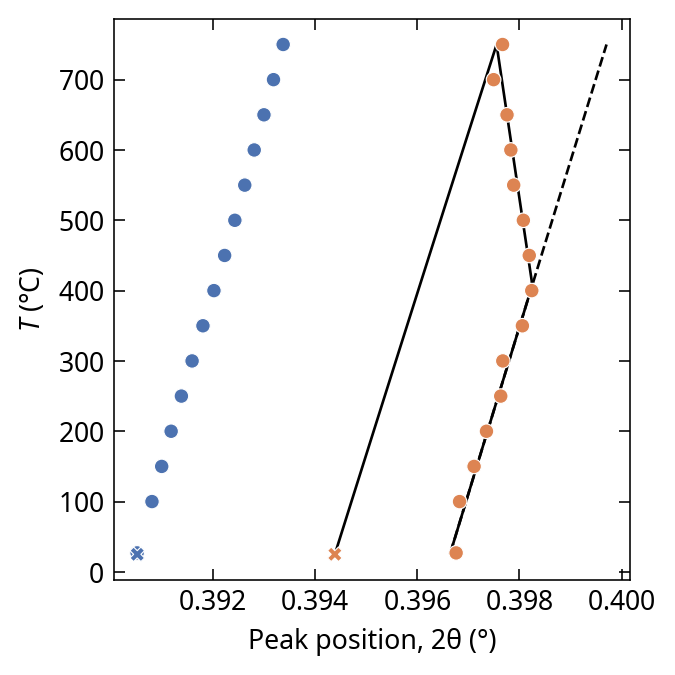

In [8]:
fig, ax = plt.subplots(figsize=(3.4, 3.4))

best_params = best_params.with_columns(
    (pl.col("temperature") == 25).alias("is_last")
).sort("is_last")


sns.scatterplot(
    best_params.select("temperature", "c1", "c2", "is_last").melt(
        id_vars=["temperature", "is_last"], variable_name="peak", value_name="position"
    ),
    y="temperature",
    x="position",
    hue="peak",
    style="is_last",
    s=30,
    palette="deep",
    legend=False,
)


def line(x, slope, intercept):
    return slope * x + intercept


def piecewise_linear(x, x_12, slope1, intercept1, slope2, intercept):
    return np.piecewise(
        x,
        [x <= x_12, x > x_12],
        [
            lambda x: line(x - x_12, slope1, intercept),
            lambda x: line(x - x_12, slope2, intercept),
        ],
    )


line_model = lm.Model(line)
line_params = line_model.make_params(slope=-4e-4, intercept=45)
temperature, center = best_params.filter(~pl.col("is_last")).select(
    ["temperature", "cen1"]
)
temperature, center = temperature.to_numpy(), center.to_numpy()
line_fitresult = line_model.fit(center, params=line_params, x=temperature)

piecewise_model = lm.Model(piecewise_linear)
piecewise_params = piecewise_model.make_params(
    x_12=420, slope1=-4e-4, intercept=45, slope2=4e-4
)
temperature, center = (
    best_params.filter(~pl.col("is_last"))
    .select(["temperature", "cen2"])
    .sort("temperature")
    .get_columns()
)
temperature, center = temperature.to_numpy(), center.to_numpy()
piecewise_fitresult = piecewise_model.fit(
    center, params=piecewise_params, x=temperature
)

temperature_dense = np.linspace(temperature[0], temperature[-1], 100)
ax.plot(
    to_distance(piecewise_fitresult.eval(x=temperature_dense)),
    temperature_dense,
    color="black",
    zorder=-1,
)
ax.plot(
    to_distance(
        line(
            temperature_dense - piecewise_fitresult.params["x_12"],
            piecewise_fitresult.params["slope1"],
            piecewise_fitresult.params["intercept"],
        )
    ),
    temperature_dense,
    color="black",
    linestyle="--",
    zorder=-1,
)

temperature_after, center_after = (
    best_params.filter(pl.col("is_last")).select(["temperature", "cen2"]).row(0)
)
temperature_max, center_max = (
    temperature[-1],
    piecewise_fitresult.eval(x=temperature)[-1],
)
slope_after = (center_after - center_max) / (temperature_after - temperature_max)
intercept_after = center_after - slope_after * temperature_after


ax.plot(
    to_distance(line(temperature_dense, slope_after, intercept_after)),
    temperature_dense,
    color="black",
    zorder=-1,
)

ax.set(ylabel=r"$T$ (°C)", xlabel="Peak position, 2θ (°)")
plt.show()

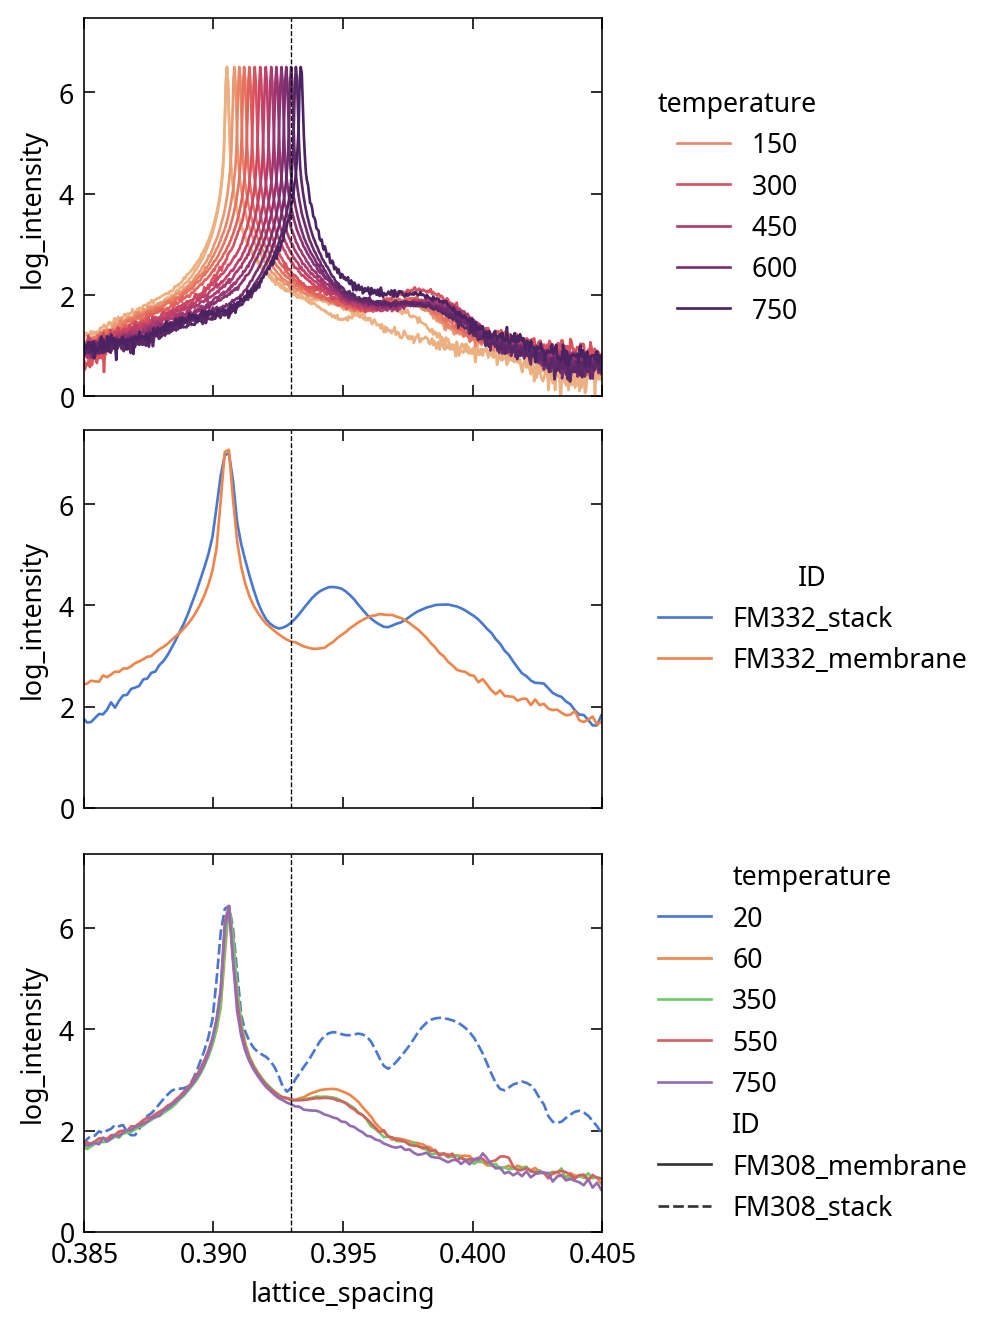

In [9]:
fig, ax = plt.subplots(3, 1, figsize=(5.1, 6.8), sharey=True, sharex=True)

g = sns.lineplot(
    xrd_data,
    x="lattice_spacing",
    y="log_intensity",
    hue="temperature",
    palette="flare",
    ax=ax[0],
)
sns.move_legend(g, bbox_to_anchor=(1.05, 0.5), loc="center left")

g = sns.lineplot(
    delft_FM332,
    x="lattice_spacing",
    y="log_intensity",
    hue="ID",
    palette="muted",
    ax=ax[1],
)
sns.move_legend(g, bbox_to_anchor=(1.05, 0.5), loc="center left")

g = sns.lineplot(
    delft_FM308,
    x="lattice_spacing",
    y="log_intensity",
    hue="temperature",
    style="ID",
    legend=True,
    palette="muted",
    ax=ax[2],
)
sns.move_legend(g, bbox_to_anchor=(1.05, 0.5), loc="center left")

for i in range(len(ax)):
    ax[i].axvline(x=0.393, c="black", linestyle="--", linewidth=0.5)
    ax[i].set(xlim=(0.385, 0.405), ylim=(0, None))

plt.show()

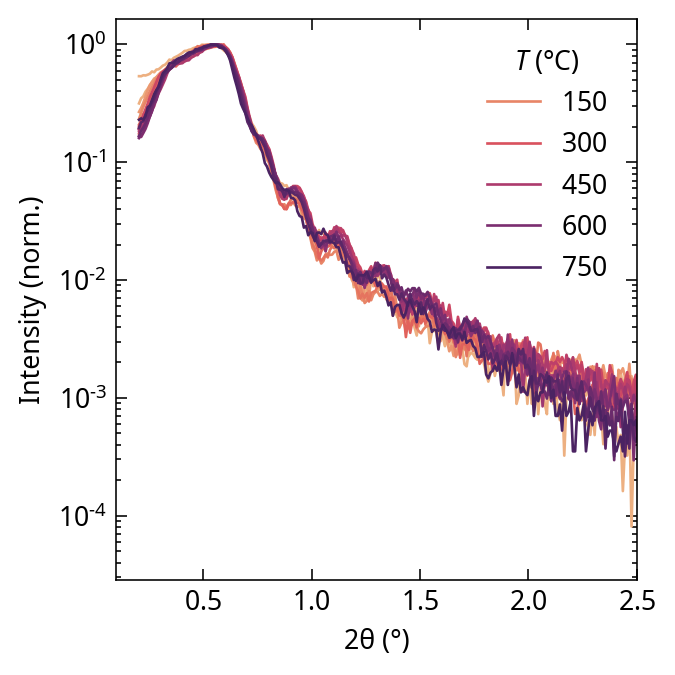

In [10]:
folder = Path("data/heating/XRR1")
filenames = folder.glob("*.xrdml")

xrr_data = (
    pl.concat(
        pl.DataFrame(
            xu.io.getxrdml_scan(filename),
            schema={"2theta": pl.Float64, "intensity": pl.Float64},
        ).with_columns(
            pl.lit(float(re.search(r"(\d+)(?=øC)", filename.name).group())).alias(
                "temperature"
            )
        )
        for filename in filenames
    )
    .with_columns(
        pl.col("temperature").replace(temperature_order).cast(pl.Int32).alias("number")
    )
    .sort("number", "2theta")
    .with_columns((pl.col("intensity") / pl.col("intensity").max()).over("temperature"))
)

g = sns.lineplot(
    xrr_data, x="2theta", y="intensity", hue="temperature", palette="flare"
)
g.set(yscale="log", xlim=(0.1, 2.5), xlabel="2θ (°)", ylabel="Intensity (norm.)")
g.legend(title=r"$T$ (°C)")

plt.show()

In [11]:
best_params = []


def fit_xrd(data: pl.DataFrame):
    x = data["2theta"].to_numpy()
    y = data["log_intensity"].to_numpy()
    temperature = data["temperature"][0]

    fit_range = slice(250, 600)
    center_sto = 46.5 - (46.5 - 46.1) / 725 * temperature

    # (name, value, vary, min, max)
    pseudovoigt_params.add_many(
        ("amp1", 3e6, True, 1e6, 4e6),
        ("cen1", center_sto, True, 0, None),
        ("sigma1", 0.005, True, 0, 1e-2),
        ("fraction1", 0.9, True, 0, 1),
        ("amp2", 60, True, 10, 100),
        ("cen2", 45.8, True, 45.2, 46.3),
        ("sigma2", 0.15, True, 0.05, 0.35),
        ("fraction2", 1, True, 0, 1),
    )

    pseudovoigt_fitresult = pseudovoigt_model.fit(
        y[fit_range], pseudovoigt_params, x=x[fit_range], method="nelder-mead"
    )
    best_params.append(
        {"temperature": temperature} | pseudovoigt_fitresult.params.valuesdict()
    )

    data = data.with_columns(pl.lit(pseudovoigt_fitresult.eval(x=x)).alias("best_fit"))

    return data


xrd_data = xrd_data.group_by(["temperature"]).map_groups(fit_xrd)
best_params = pl.DataFrame(best_params).with_columns(
    pl.col("cen1").map_batches(to_distance).alias("c1"),
    pl.col("cen2").map_batches(to_distance).alias("c2"),
)

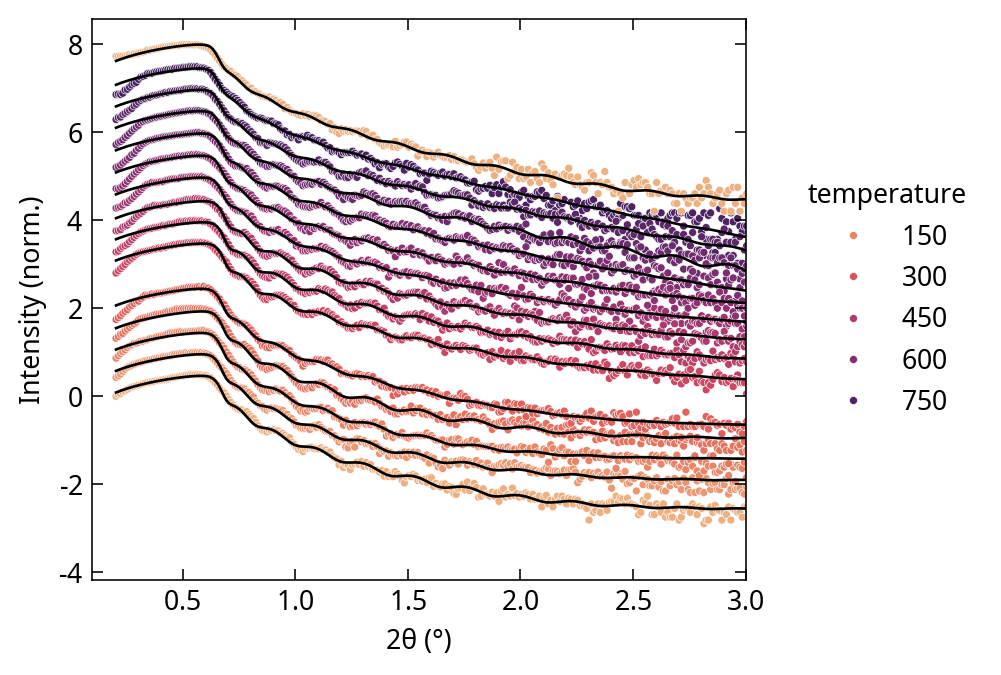

In [12]:
STO = xu.materials.SrTiO3
SRO = xu.materials.Crystal(
    "SrRuO3",
    xu.materials.SGLattice(
        123, 3.905, 3.95, atoms=[Sr, Ru, O, O], pos=["1a", "1d", "1c", "2e"]
    ),
)

sub = xu.simpack.Layer(STO, float("inf"), roughness=1, density=5130)
lay1 = xu.simpack.Layer(SRO, 350, roughness=4, density=5700)
m = xu.simpack.SpecularReflectivityModel(
    sub + lay1,
    energy="CuKa1",
    sample_width=5,
    beam_width=0.4,
    resolution_width=0.002,
    background=2,
    I0=1,
)
fitm = xu.simpack.FitModel(m)

fitm.set_param_hint("SrTiO3_density", vary=False)
fitm.set_param_hint("SrTiO3_roughness", vary=True, value=1, min=0)
fitm.set_param_hint("SrRuO3_density", vary=True, value=5600)
fitm.set_param_hint("SrRuO3_thickness", vary=True, value=350, min=300, max=400)
fitm.set_param_hint("SrRuO3_roughness", vary=True, value=6, min=0, max=10)
fitm.set_param_hint("I0", vary=True, value=20)
fitm.set_param_hint("background", vary=True, value=0)
p = fitm.make_params()

best_params = []


def fit_xrr(data: pl.DataFrame):
    x = data["2theta"].to_numpy()
    y = data["intensity"].to_numpy()
    temperature = data["temperature"][0]

    p = fitm.make_params()

    fit_range = slice(20, 250)
    result = fitm.fit(y[fit_range], p, x[fit_range] / 2)

    data = data.with_columns(pl.lit(result.eval(x=x / 2)).alias("fit"))
    best_params.append({"temperature": temperature} | result.params.valuesdict())

    return data


fig, ax = plt.subplots(figsize=(5.1, 3.4))
offset = 5e-1 * pl.col("number")
plot_data = (
    xrr_data.group_by(["temperature"])
    .map_groups(fit_xrr)
    .with_columns(
        (pl.col("intensity").log10() + offset).alias("log_intensity"),
        (pl.col("fit").log10() + offset).alias("log_fit"),
    )
)
best_params = pl.DataFrame(best_params)
sns.lineplot(
    plot_data,
    x="2theta",
    y="log_fit",
    color="black",
    units="temperature",
    estimator=None,
    legend=False,
    ax=ax,
)
g = sns.scatterplot(
    plot_data,
    x="2theta",
    y="log_intensity",
    hue="temperature",
    palette="flare",
    legend=True,
    ax=ax,
)
sns.move_legend(g, bbox_to_anchor=(1.05, 0.5), loc="center left")
ax.set(xlim=(0.1, 3.0), xlabel="2θ (°)", ylabel="Intensity (norm.)")
plt.show()

/Users/monochromatti/miniconda3/envs/scicomp/lib/python3.12/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


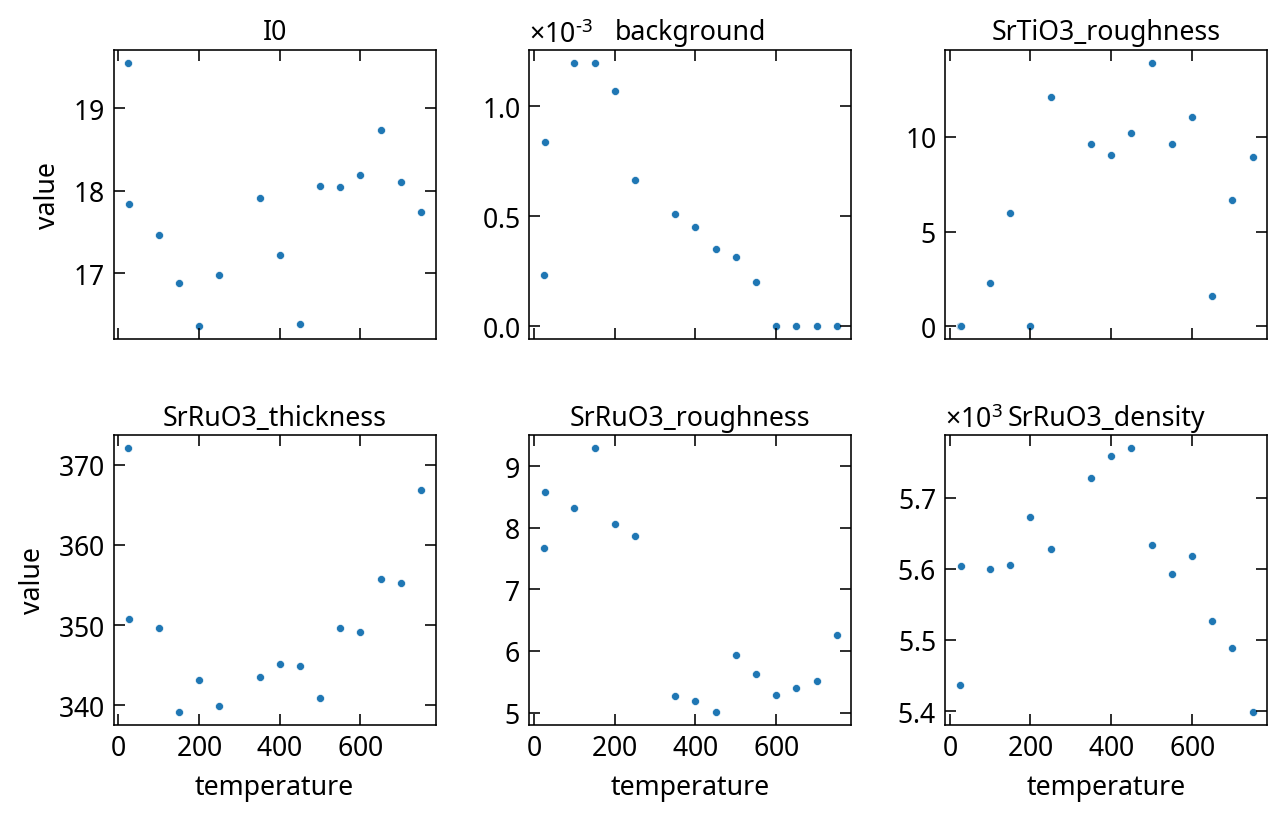

In [13]:
g = sns.relplot(
    best_params.select(
        "temperature",
        "I0",
        "background",
        "SrTiO3_roughness",
        "SrRuO3_thickness",
        "SrRuO3_roughness",
        "SrRuO3_density",
    ).melt(id_vars="temperature"),
    x="temperature",
    y="value",
    col="variable",
    facet_kws=dict(sharey=False, despine=False),
    col_wrap=3,
    height=6.8 / 3,
    aspect=1,
)
g.set_titles("{col_name}")
plt.show()